<a href="https://colab.research.google.com/github/Abirmai369/Movie-Success-Prediction-and-Sentiment-Study/blob/main/Movie_Success_Prediction_and_Sentiment_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                     title  \
0                                GoldenEye   
1                                   Friday   
2                      From Dusk Till Dawn   
3                         Blue in the Face   
4  Mighty Morphin Power Rangers: The Movie   

                                              genres  vote_count  \
0  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...        1194   
1                     [{'id': 35, 'name': 'Comedy'}]         513   
2  [{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...        1644   
3                     [{'id': 35, 'name': 'Comedy'}]          28   
4  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...         153   

   vote_average    budget    revenue  \
0           6.6  58000000  352194034   
1           7.0   3500000   28215918   
2           6.9  19000000   25836616   
3           6.8   2000000    1275000   
4           5.2  15000000   66000000   

                                            overview  
0  James Bond must

/tmp/ipython-input-2-2674085853.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_avg.values, y=genre_avg.index, palette="viridis")


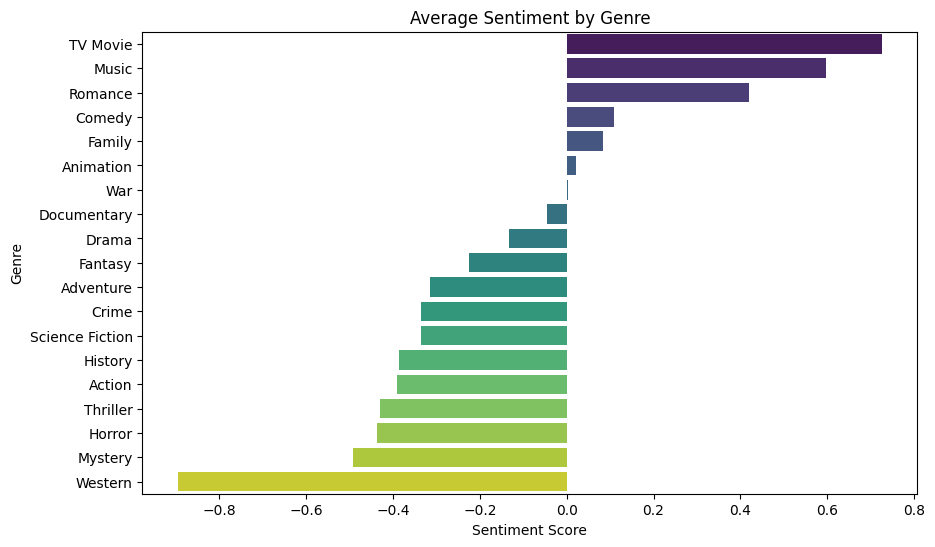

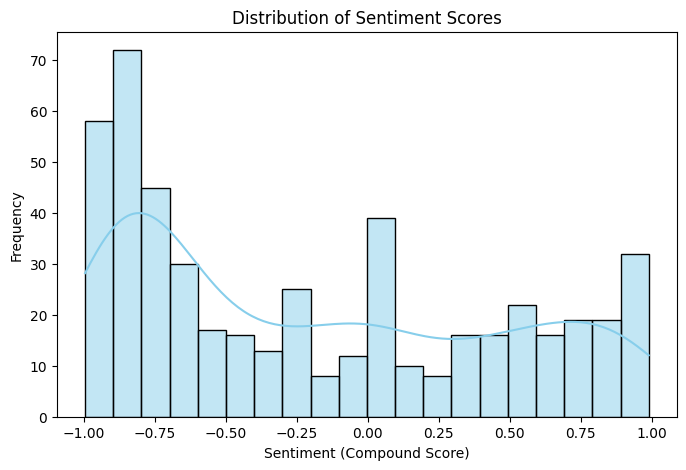

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
df = pd.read_csv("movies_metadata.csv", low_memory=False)

# Keep relevant columns
df = df[['title', 'genres', 'vote_count', 'vote_average', 'budget', 'revenue', 'overview']]
df = df.dropna(subset=['title', 'overview'])
print(df.head())
import requests
from bs4 import BeautifulSoup

url = "https://www.imdb.com/chart/top/ "
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

titles = [item.text.split('\n')[1] for item in soup.select("li.ipc-metadata-list-summary-item__t")]
ratings = [float(item['data-value']) for item in soup.select("span[data-testid='rating-score']")]

imdb_df = pd.DataFrame({'title': titles, 'rating': ratings})
sia = SentimentIntensityAnalyzer()

# Sample reviews (you can replace this with real user reviews)
reviews = [
    "This movie was fantastic!",
    "Terrible acting and boring plot.",
    "It was okay, not great but not bad either."
]

sentiments = [sia.polarity_scores(review)['compound'] for review in reviews]
print(sentiments)
df['sentiment'] = df['overview'].apply(lambda x: sia.polarity_scores(x)['compound'])
# Filter out rows where budget or revenue is zero or missing
df_clean = df[(df['budget'] != '0') & (df['revenue'] != '0')].copy()
df_clean['budget'] = pd.to_numeric(df_clean['budget'], errors='coerce')
df_clean['revenue'] = pd.to_numeric(df_clean['revenue'], errors='coerce')
df_clean = df_clean.dropna(subset=['budget', 'revenue'])

X = df_clean[['budget', 'vote_average', 'vote_count', 'sentiment']]
y = df_clean['revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Metrics
print("R²:", r2_score(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
import ast

def extract_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return [genre['name'] for genre in genres]
    except:
        return []

df['genre_list'] = df['genres'].apply(extract_genres)

# Explode into separate rows for each genre
genre_sentiment = df.explode('genre_list')[['genre_list', 'sentiment']].dropna()
genre_avg = genre_sentiment.groupby('genre_list')['sentiment'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_avg.values, y=genre_avg.index, palette="viridis")
plt.title("Average Sentiment by Genre")
plt.xlabel("Sentiment Score")
plt.ylabel("Genre")
plt.show()
plt.figure(figsize=(8, 5))
sns.histplot(df['sentiment'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment (Compound Score)")
plt.ylabel("Frequency")
plt.show()